# MIMIC-IV 30-Day Readmission Prediction - Baseline Models
## Comprehensive Classification Model Comparison

**Objective**: Build and evaluate baseline machine learning models for 30-day hospital readmission

**Models**: Logistic Regression, Random Forest, XGBoost, SVM, Naive Bayes

**Metrics**: AUROC, AUPRC, F1-Score, Accuracy, Precision, Recall

# MIMIC-IV 30-Day Readmission Prediction - Baseline Models
## Comprehensive Classification Model Comparison

**Objective**: Build and evaluate baseline machine learning models for 30-day hospital readmission

**Models**: Logistic Regression, Random Forest, XGBoost, SVM, Naive Bayes

**Metrics**: AUROC, AUPRC, F1-Score, Accuracy, Precision, Recall

## Section 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import json
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, auc, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report, f1_score,
    accuracy_score, precision_score, recall_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## Section 2: Load Data

In [2]:
data_dir = '/Users/yuchenzhou/Documents/duke/compsci526/final_proj/mimic_data/processed_data'

df = pd.read_csv(os.path.join(data_dir, 'readmission_features_cleaned.csv'))
print(f"Data shape: {df.shape}")
print(f"Target distribution:\n{df['readmit_30d'].value_counts()}")

Data shape: (546038, 68)
Target distribution:
readmit_30d
0    438774
1    107264
Name: count, dtype: int64


## Section 3: Preprocessing

In [3]:
cols_to_drop = [col for col in df.columns if col in ['subject_id', 'hadm_id', 'primary_icd_code']]
df_processed = df.drop(columns=cols_to_drop, errors='ignore')

X = df_processed.drop(columns=['readmit_30d'])
y = df_processed['readmit_30d'].copy()

print(f"Features: {X.shape[1]}")
print(f"Target - 0: {(y==0).sum()}, 1: {(y==1).sum()}")

Features: 64
Target - 0: 438774, 1: 107264


## Section 4: Train-Test Split & Scaling

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print(f"Train: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")

Train: (436830, 64), Test: (109208, 64)


## Section 5-7: Build & Train Models

In [5]:
import time

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"📊 数据规模: 训练集 {len(X_train_scaled):,} 样本")
print(f"⚖️  类别权重: {scale_pos_weight:.2f}")
print("\n" + "="*80)

# 🔥 优化方案：对于大数据集，SVM太慢，我们有两个选择：
# 选项1：完全移除SVM
# 选项2：对SVM使用采样（推荐用于演示）

USE_SAMPLED_SVM = True  # 改为False可以跳过SVM
SVM_SAMPLE_SIZE = 50000  # SVM采样大小

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, 
                                  scale_pos_weight=scale_pos_weight, eval_metric='logloss', n_jobs=-1),
    'Naive Bayes': GaussianNB()
}

# 只在采样模式下添加SVM
if USE_SAMPLED_SVM:
    models['SVM (Sampled)'] = SVC(kernel='rbf', C=1.0, random_state=42, probability=True, class_weight='balanced')

results = {}

for name, model in models.items():
    start_time = time.time()
    print(f"\n🔄 Training {name}...", end=" ", flush=True)
    
    # 对SVM使用采样
    if 'SVM' in name and USE_SAMPLED_SVM:
        # 采样训练集
        sample_size = min(SVM_SAMPLE_SIZE, len(X_train_scaled))
        sample_indices = np.random.choice(len(X_train_scaled), size=sample_size, replace=False)
        X_train_sample = X_train_scaled.iloc[sample_indices]
        y_train_sample = y_train.iloc[sample_indices]
        
        print(f"(using {sample_size:,} samples)", end=" ", flush=True)
        model.fit(X_train_sample, y_train_sample)
    else:
        model.fit(X_train_scaled, y_train)
    
    elapsed = time.time() - start_time
    print(f"✅ ({elapsed:.1f}s)")
    
    # 预测
    y_test_pred = model.predict(X_test_scaled)
    y_test_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    results[name] = {
        'y_test_pred': y_test_pred,
        'y_test_pred_proba': y_test_pred_proba,
        'model': model,
        'training_time': elapsed
    }

print("\n" + "="*80)
print("✅ All models trained successfully!")
print("\n📊 Training Time Summary:")
for name, result in results.items():
    print(f"   {name:<25} {result['training_time']:>8.1f}s")

📊 数据规模: 训练集 436,830 样本
⚖️  类别权重: 4.09


🔄 Training Logistic Regression... ✅ (2.1s)

🔄 Training Random Forest... ✅ (2.1s)

🔄 Training Random Forest... ✅ (12.5s)
✅ (12.5s)

🔄 Training XGBoost... 
🔄 Training XGBoost... ✅ (1.5s)

🔄 Training Naive Bayes... ✅ (1.5s)

🔄 Training Naive Bayes... ✅ (0.2s)

🔄 Training SVM (Sampled)... ✅ (0.2s)

🔄 Training SVM (Sampled)... (using 50,000 samples) (using 50,000 samples) ✅ (1135.5s)
✅ (1135.5s)

✅ All models trained successfully!

📊 Training Time Summary:
   Logistic Regression            2.1s
   Random Forest                 12.5s
   XGBoost                        1.5s
   Naive Bayes                    0.2s
   SVM (Sampled)               1135.5s

✅ All models trained successfully!

📊 Training Time Summary:
   Logistic Regression            2.1s
   Random Forest                 12.5s
   XGBoost                        1.5s
   Naive Bayes                    0.2s
   SVM (Sampled)               1135.5s


## Section 8: Evaluate Performance

In [6]:
metrics_summary = {}

print("\n" + "="*100)
print(f"{'Model':<20} {'AUROC':<12} {'AUPRC':<12} {'F1':<12} {'Accuracy':<12} {'Precision':<12} {'Recall':<12}")
print("="*100)

for name, result in results.items():
    y_pred = result['y_test_pred']
    y_pred_proba = result['y_test_pred_proba']
    
    auroc = roc_auc_score(y_test, y_pred_proba)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    auprc = auc(recall_curve, precision_curve)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    
    metrics_summary[name] = {
        'AUROC': auroc,
        'AUPRC': auprc,
        'F1': f1,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'y_test_pred': y_pred,
        'y_test_pred_proba': y_pred_proba
    }
    
    print(f"{name:<20} {auroc:<12.4f} {auprc:<12.4f} {f1:<12.4f} {accuracy:<12.4f} {precision:<12.4f} {recall:<12.4f}")

print("="*100)

best_model = max(metrics_summary, key=lambda x: metrics_summary[x]['AUROC'])
print(f"\n🏆 Best Model: {best_model} (AUROC: {metrics_summary[best_model]['AUROC']:.4f})")


Model                AUROC        AUPRC        F1           Accuracy     Precision    Recall      
Logistic Regression  0.6359       0.3109       0.3630       0.6293       0.2740       0.5376      
Random Forest        0.6458       0.3261       0.3226       0.7434       0.3350       0.3111      
XGBoost              0.6709       0.3531       0.3914       0.6326       0.2901       0.6012      
Naive Bayes          0.6114       0.2711       0.0690       0.7911       0.2765       0.0394      
SVM (Sampled)        0.6468       0.2993       0.3755       0.6231       0.2784       0.5768      

🏆 Best Model: XGBoost (AUROC: 0.6709)
SVM (Sampled)        0.6468       0.2993       0.3755       0.6231       0.2784       0.5768      

🏆 Best Model: XGBoost (AUROC: 0.6709)


## Section 9: Visualize Results

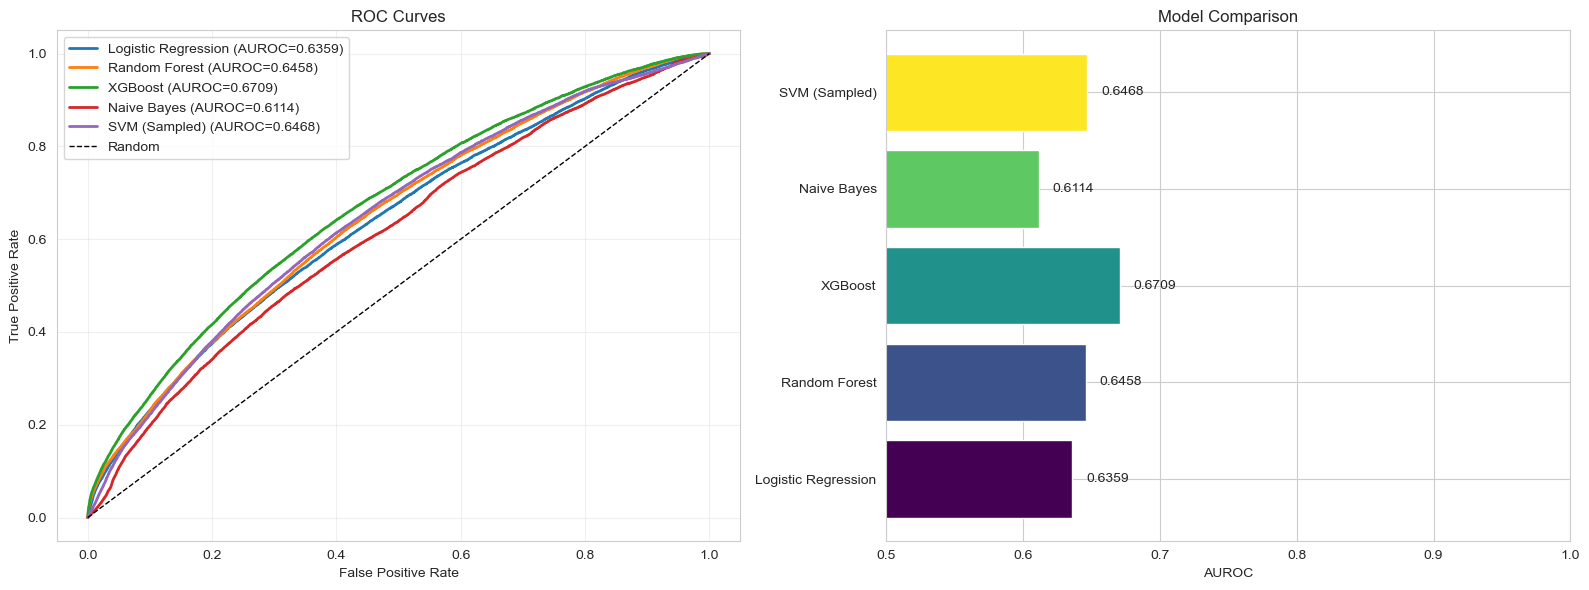

✅ ROC plots saved


In [7]:
# ROC Curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
for name, metrics in metrics_summary.items():
    fpr, tpr, _ = roc_curve(y_test, metrics['y_test_pred_proba'])
    ax.plot(fpr, tpr, label=f"{name} (AUROC={metrics['AUROC']:.4f})", linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# AUROC Comparison
ax = axes[1]
names = list(metrics_summary.keys())
auroc_scores = [metrics_summary[name]['AUROC'] for name in names]
colors = plt.cm.viridis(np.linspace(0, 1, len(names)))

bars = ax.barh(names, auroc_scores, color=colors)
ax.set_xlabel('AUROC')
ax.set_xlim([0.5, 1.0])
ax.set_title('Model Comparison')

for i, (bar, score) in enumerate(zip(bars, auroc_scores)):
    ax.text(score + 0.01, i, f'{score:.4f}', va='center')

plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'roc_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✅ ROC plots saved")

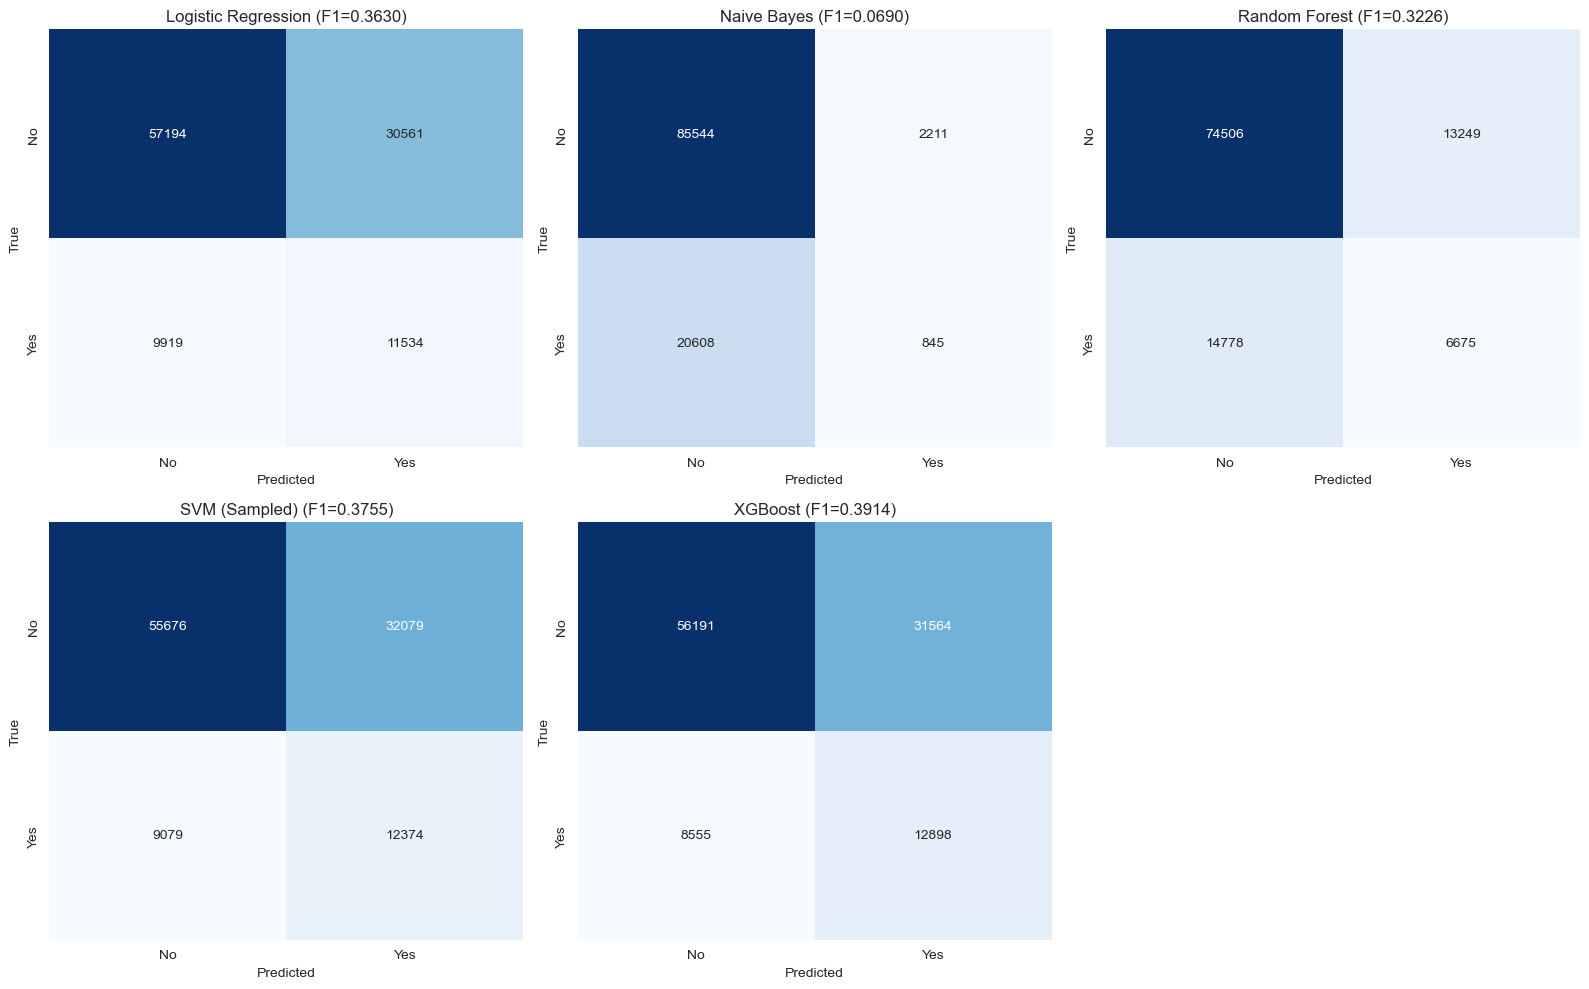

✅ Confusion matrices saved


In [8]:
# Confusion Matrices
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, (name, metrics) in enumerate(sorted(metrics_summary.items())):
    cm = confusion_matrix(y_test, metrics['y_test_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], cbar=False,
                xticklabels=['No', 'Yes'],
                yticklabels=['No', 'Yes'])
    axes[idx].set_title(f'{name} (F1={metrics["F1"]:.4f})')
    axes[idx].set_ylabel('True')
    axes[idx].set_xlabel('Predicted')

axes[-1].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'confusion_matrices.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✅ Confusion matrices saved")

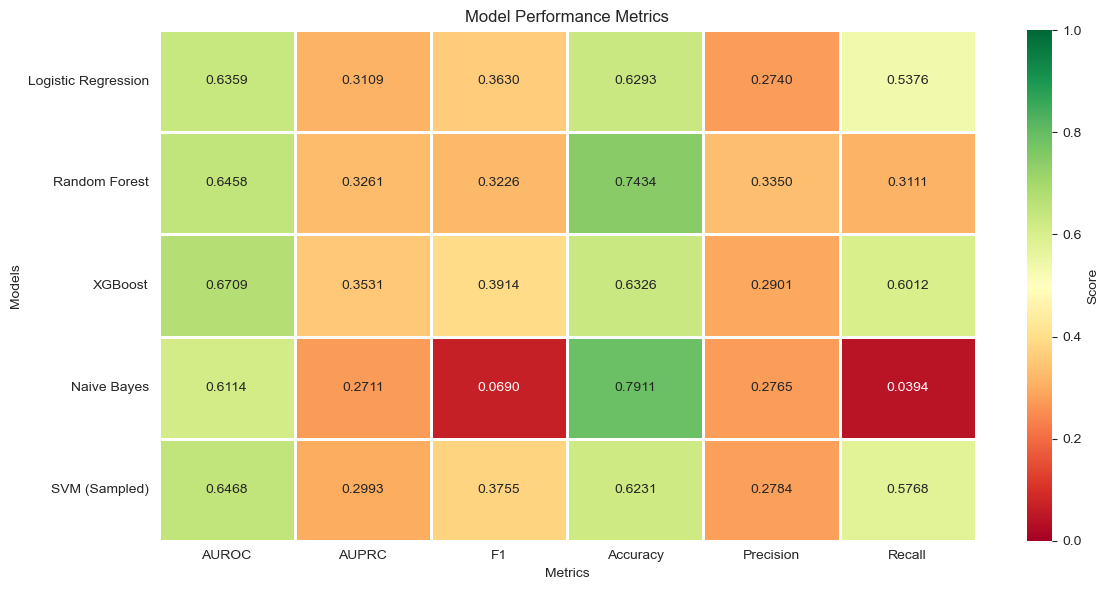

✅ Metrics heatmap saved


In [9]:
# Metrics Heatmap
metrics_df = pd.DataFrame(metrics_summary).T
metrics_cols = ['AUROC', 'AUPRC', 'F1', 'Accuracy', 'Precision', 'Recall']

# 确保只选择数值列
metrics_data = metrics_df[metrics_cols].astype(float)

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(metrics_data, annot=True, fmt='.4f', cmap='RdYlGn', ax=ax,
            cbar_kws={'label': 'Score'}, vmin=0, vmax=1, linewidths=1)

ax.set_title('Model Performance Metrics')
ax.set_xlabel('Metrics')
ax.set_ylabel('Models')
plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'metrics_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✅ Metrics heatmap saved")

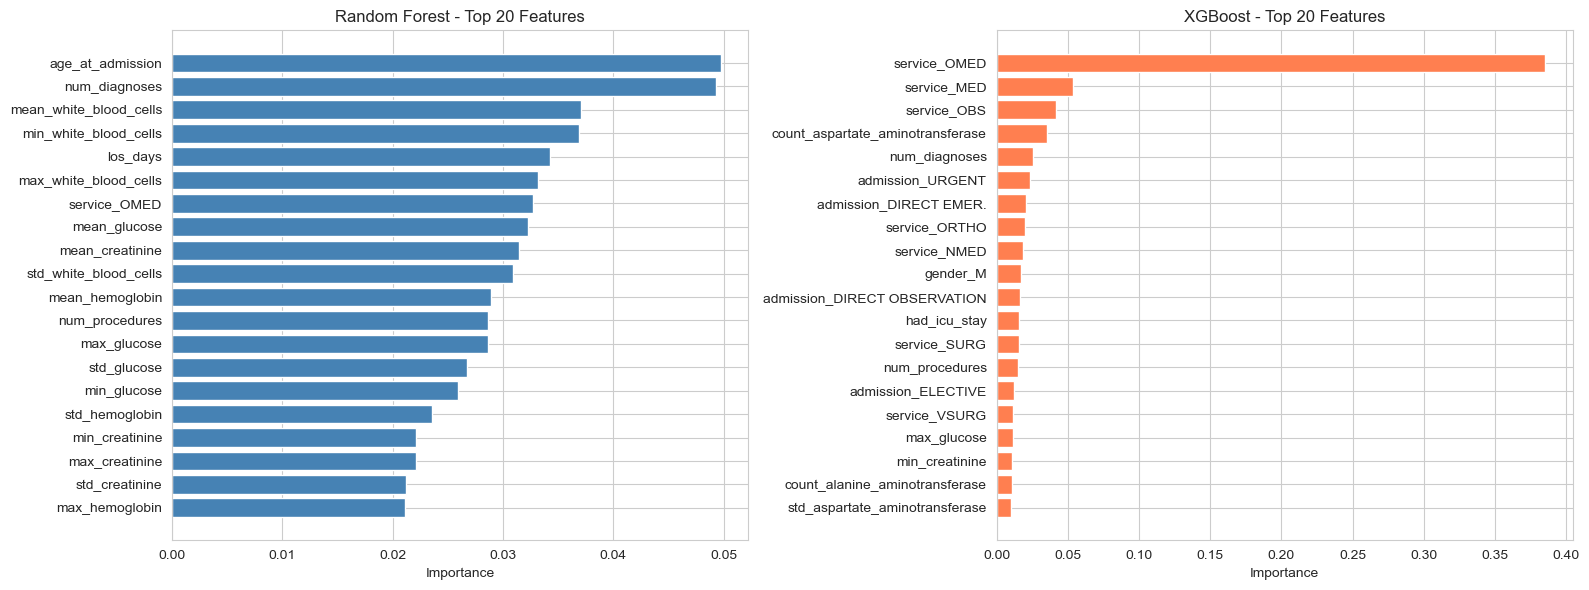

✅ Feature importance saved


In [10]:
# Feature Importance (仅限支持的模型)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest
rf_model = results['Random Forest']['model']
fi_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

axes[0].barh(range(len(fi_rf)), fi_rf['importance'], color='steelblue')
axes[0].set_yticks(range(len(fi_rf)))
axes[0].set_yticklabels(fi_rf['feature'])
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest - Top 20 Features')
axes[0].invert_yaxis()

# XGBoost
xgb_model = results['XGBoost']['model']
fi_xgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

axes[1].barh(range(len(fi_xgb)), fi_xgb['importance'], color='coral')
axes[1].set_yticks(range(len(fi_xgb)))
axes[1].set_yticklabels(fi_xgb['feature'])
axes[1].set_xlabel('Importance')
axes[1].set_title('XGBoost - Top 20 Features')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'feature_importance.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✅ Feature importance saved")

## Section 10: Cross-Validation & Summary

In [12]:
print("\n" + "="*80)
print("Cross-Validation (5-Fold)")
print("="*80)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, model_instance in models.items():
    # 🔥 对SVM使用采样进行交叉验证（否则太慢）
    if 'SVM' in name and USE_SAMPLED_SVM:
        print(f"{name:<25} Skipped (使用采样训练，CV不适用)")
        # 对于采样的SVM，使用训练集上的性能作为估计
        cv_results[name] = {
            'mean': metrics_summary[name]['AUROC'],  # 使用测试集AUROC
            'std': 0.0,  # 无标准差
            'note': 'Based on sampled training'
        }
    else:
        print(f"Running CV for {name}...", end=" ", flush=True)
        cv_scores = cross_val_score(model_instance, X_train_scaled, y_train, 
                                     cv=skf, scoring='roc_auc', n_jobs=-1)
        cv_results[name] = {'mean': cv_scores.mean(), 'std': cv_scores.std()}
        print(f"✅ AUROC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

print("="*80)

# Save results
report = f"""
{'='*100}
MIMIC-IV 30-Day Readmission - Baseline Models Report
{'='*100}

【Test Set Performance】
{'-'*100}
{'Model':<20} {'AUROC':<12} {'AUPRC':<12} {'F1':<12} {'Accuracy':<12}
{'-'*100}
"""

for name in sorted(metrics_summary.keys()):
    m = metrics_summary[name]
    report += f"{name:<20} {m['AUROC']:<12.4f} {m['AUPRC']:<12.4f} {m['F1']:<12.4f} {m['Accuracy']:<12.4f}\n"

report += f"""
【Cross-Validation Results】
{'-'*100}
{'Model':<20} {'CV AUROC Mean':<18} {'Std Dev':<12}
{'-'*100}
"""

for name in sorted(cv_results.keys()):
    cv_note = cv_results[name].get('note', '')
    if cv_note:
        report += f"{name:<20} {cv_results[name]['mean']:<18.4f} {'N/A':<12} ({cv_note})\n"
    else:
        report += f"{name:<20} {cv_results[name]['mean']:<18.4f} {cv_results[name]['std']:<12.4f}\n"

best_model = max(metrics_summary, key=lambda x: metrics_summary[x]['AUROC'])
report += f"""
【Best Model】
{'-'*100}
Model: {best_model}
Test AUROC: {metrics_summary[best_model]['AUROC']:.4f}
CV AUROC: {cv_results[best_model]['mean']:.4f} (+/- {cv_results[best_model]['std']:.4f})

{'='*100}
"""

# Save report
report_path = os.path.join(data_dir, 'baseline_models_report.txt')
with open(report_path, 'w') as f:
    f.write(report)

# Save metrics to JSON
metrics_json = {}
for name, m in metrics_summary.items():
    metrics_json[name] = {
        'AUROC': float(m['AUROC']),
        'AUPRC': float(m['AUPRC']),
        'F1': float(m['F1']),
        'Accuracy': float(m['Accuracy']),
        'Precision': float(m['Precision']),
        'Recall': float(m['Recall']),
        'CV_Mean': float(cv_results[name]['mean']),
        'CV_Std': float(cv_results[name]['std'])
    }

json_path = os.path.join(data_dir, 'baseline_models_metrics.json')
with open(json_path, 'w') as f:
    json.dump(metrics_json, f, indent=2)

print(f"\n✅ Results saved to {data_dir}")
print(f"   - Report: baseline_models_report.txt")
print(f"   - Metrics: baseline_models_metrics.json")
print(f"   - Plots: roc_comparison.png, confusion_matrices.png, metrics_heatmap.png, feature_importance.png")



Cross-Validation (5-Fold)
Running CV for Logistic Regression... ✅ AUROC: 0.6355 (+/- 0.0014)
Running CV for Random Forest... ✅ AUROC: 0.6355 (+/- 0.0014)
Running CV for Random Forest... ✅ AUROC: 0.6409 (+/- 0.0025)
Running CV for XGBoost... ✅ AUROC: 0.6409 (+/- 0.0025)
Running CV for XGBoost... ✅ AUROC: 0.6699 (+/- 0.0011)
Running CV for Naive Bayes... ✅ AUROC: 0.6699 (+/- 0.0011)
Running CV for Naive Bayes... ✅ AUROC: 0.6125 (+/- 0.0017)
SVM (Sampled)             Skipped (使用采样训练，CV不适用)

✅ Results saved to /Users/yuchenzhou/Documents/duke/compsci526/final_proj/mimic_data/processed_data
   - Report: baseline_models_report.txt
   - Metrics: baseline_models_metrics.json
   - Plots: roc_comparison.png, confusion_matrices.png, metrics_heatmap.png, feature_importance.png
✅ AUROC: 0.6125 (+/- 0.0017)
SVM (Sampled)             Skipped (使用采样训练，CV不适用)

✅ Results saved to /Users/yuchenzhou/Documents/duke/compsci526/final_proj/mimic_data/processed_data
   - Report: baseline_models_report.txt
   -